In [1]:
# !pip install vl-convert-python
# !pip install svgutils
# !pip install lxml

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from pyvis import network as net
import json
from os import listdir
import requests
import io


import datashader as ds
import datashader.transfer_functions as tf
from datashader.bundling import hammer_bundle
import vl_convert as vlc
import svgutils.transform as st

import json
from vl_convert import vegalite_to_svg
from lxml import etree
import xml.etree.ElementTree as ET

pd.options.display.max_columns = None

/N/u/abagra/BigRed200/anaconda3/lib/python3.12/site-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "/N/u/abagra/BigRed200/anaconda3/lib/python3.12/site-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 254, in ensure_initialized
    self.cuInit(0)
  File "/N/u/abagra/BigRed200/anaconda3/lib/python3.12/site-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 304, in safe_cuda_api_call
    self._check_ctypes_error(fname, retcode)
  File "/N/u/abagra/BigRed200/anaconda3/lib/python3.12/site-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 372, in _check_ctypes_error
    raise CudaAPIError(retcode, msg)
numba.cuda.cudadrv.driver.CudaAPIError: [100] Call to cuInit results in CUDA_ERROR_NO_DEVICE

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/N/u/abagra/BigRed20

## Data Paths

In [3]:
# nodes_url = "https://raw.githubusercontent.com/cns-iu/hra-ftu-vccf-supporting-information/main/code/data/asct-nodes.csv" 
# edges_url = "https://raw.githubusercontent.com/cns-iu/hra-ftu-vccf-supporting-information/main/code/data/asct-edges.csv"
# blood_edges_url = "https://raw.githubusercontent.com/cns-iu/hra-ftu-vccf-supporting-information/main/code/data/asct-blood-vasculature-edges.csv"

#use build_network.py to build data for latest release and save it in folder data

nodes_url = "data/asct-nodes.csv" 
edges_url = "data/asct-edges.csv"
blood_edges_url = "data/asct-blood-vasculature-edges.csv"

output_path = "./viz_v2.0"
## Make sure to save vega_config file in output_path/vega_config/

canvas_size = 1720

## Code

In [4]:
nodes = pd.read_csv(nodes_url)
edges = pd.read_csv(edges_url)

In [5]:
omitted_organs = ['muscular_system', 'skeleton'] + ['lymph_vasculature', 'peripheral_nervous_system', 'blood_pelvis',] 


nodes = nodes[~nodes['organ'].isin(omitted_organs)]
edges = edges[~edges['organ'].isin(omitted_organs)]

In [6]:
edges

,organ,source,target,source_type,target_type
0,blood_vasculature,UBERON:0013702,UBERON:0000948,AS,AS
1,allen_brain,UBERON:0013702,UBERON:0000955,AS,AS
3,bone_marrow,UBERON:0013702,UBERON:0002371,AS,AS
4,eye,UBERON:0013702,UBERON:0000970,AS,AS
5,fallopian_tube,UBERON:0013702,UBERON:0003889,AS,AS
...,...,...,...,...,...
11923,uterus,UBERON:0011949$$8713,ASCTB-TEMP:luminal-epithelial-cell$$8714,AS,CT
11924,uterus,UBERON:0002451$$8715,UBERON:0012276$$8716,AS,AS
11925,uterus,UBERON:0002451$$8715,UBERON:0011949$$8718,AS,AS
11926,uterus,UBERON:0012276$$8716,ASCTB-TEMP:glandular-epithelial-cell$$8717,AS,CT


In [7]:
edges['organ'].value_counts()

organ
blood_vasculature    4531
ovary                2070
large_intestine      1333
allen_brain           868
uterus                696
heart                 257
lung                  206
spleen                201
small_intestine       181
pancreas              175
fallopian_tube        174
placenta              166
kidney                157
lymph_node            128
spinal_cord           127
thymus                106
skin                   90
eye                    85
palatine_tonsil        70
bone_marrow            50
liver                  48
trachea                37
prostate               34
urinary_bladder        32
knee                   29
main_bronchus          26
ureter                 21
Name: count, dtype: int64

In [8]:
nodes.duplicated(subset=['id', 'type', 'organ', 'ontology_id']).sum()

0

In [9]:
nodes.duplicated(subset=['id'], keep=False).sum()

0

In [10]:
def get_nodes(name=None, ontology_id=None):
    if name:
        return nodes[nodes['name'].str.lower()==name.lower()]
    if ontology_id:
        return nodes[nodes['ontology_id']==ontology_id]   

In [11]:
get_nodes(name='body')

,id,name,type,organ,ontology_id
0,UBERON:0013702,body,AS,body,UBERON:0013702


In [12]:
get_nodes(ontology_id='UBERON:0013702')

,id,name,type,organ,ontology_id
0,UBERON:0013702,body,AS,body,UBERON:0013702


In [13]:
whole_graph = nx.from_pandas_edgelist(edges, source='source', target='target', edge_attr=True)

In [14]:
nx.is_tree(whole_graph)

True

In [15]:
nodes

,id,name,type,organ,ontology_id
0,UBERON:0013702,body,AS,body,UBERON:0013702
1,UBERON:0000948,heart,AS,blood_vasculature,UBERON:0000948
2,UBERON:0002079,left cardiac atrium,AS,blood_vasculature,UBERON:0002079
3,CL:0010008,cardiac endothelial cell,CT,blood_vasculature,CL:0010008
4,FMA:49913,Left inferior pulmonary vein,AS,blood_vasculature,FMA:49913
...,...,...,...,...,...
11924,UBERON:0002451$$8715,endometrial gland,AS,uterus,UBERON:0002451
11925,UBERON:0012276$$8716,endometrium glandular epithelium,AS,uterus,UBERON:0012276
11926,ASCTB-TEMP:glandular-epithelial-cell$$8717,glandular epithelial cell,CT,uterus,ASCTB-TEMP:glandular-epithelial-cell
11927,UBERON:0011949$$8718,endometrium luminal epithelium,AS,uterus,UBERON:0011949


In [16]:
nodes.isna().sum()

id             0
name           0
type           0
organ          0
ontology_id    0
dtype: int64

In [17]:
organ_order = ['trachea', 'main bronchus', 'respiratory system', 'heart',  'spinal cord', 'brain', 'eye', 'palatine tonsil', 
               'skin of body', 'thymus', 'lymph node', 'spleen',  'liver', 'Pancreas', 'small intestine',  'large intestine', 
               'kidney', 'urinary bladder', 'ureter', 'prostate gland',  'ovary', 'fallopian tube', 'uterus',  
               'placenta', 'knee', 'Bone marrow']

# Nodes that are branching from the 'body' node

In [18]:
nodes[nodes['ontology_id'].isin(list(nx.neighbors(whole_graph, 'UBERON:0013702')))]

,id,name,type,organ,ontology_id
1,UBERON:0000948,heart,AS,blood_vasculature,UBERON:0000948
4535,UBERON:0000955,brain,AS,allen_brain,UBERON:0000955
5433,UBERON:0002371,Bone marrow,AS,bone_marrow,UBERON:0002371
5483,UBERON:0000970,eye,AS,eye,UBERON:0000970
5568,UBERON:0003889,fallopian tube,AS,fallopian_tube,UBERON:0003889
5996,UBERON:0002113,kidney,AS,kidney,UBERON:0002113
6153,UBERON:0001465,knee,AS,knee,UBERON:0001465
6182,UBERON:0000059,large intestine,AS,large_intestine,UBERON:0000059
7515,UBERON:0002107,liver,AS,liver,UBERON:0002107
7563,UBERON:0001004,respiratory system,AS,lung,UBERON:0001004


In [19]:
new_edges = edges[(edges['source']=='UBERON:0013702')&(edges['target'].isin(['UBERON:0008886', 'UBERON:0004573', 'UBERON:0003920']))].copy()
new_edges['source'].replace('UBERON:0013702', 'UBERON:0001004', inplace=True) #connect the nodes to respiratory system instead of body

In [20]:
new_edges

,organ,source,target,source_type,target_type
11,lung,UBERON:0001004,UBERON:0008886,AS,AS
12,lung,UBERON:0001004,UBERON:0004573,AS,AS
13,lung,UBERON:0001004,UBERON:0003920,AS,AS


In [21]:
edges = edges[~((edges['source']=='UBERON:0013702')&(edges['target'].isin(['UBERON:0008886', 'UBERON:0004573', 'UBERON:0003920'])))]
edges = pd.concat([edges, new_edges])

In [22]:
whole_graph = nx.from_pandas_edgelist(edges, source='source', target='target', edge_attr=True)

In [23]:
nx.is_tree(whole_graph)

True

In [24]:
organ_order_in_id = [get_nodes(name=organ)['id'].values[0] for organ in organ_order]

In [25]:
len(organ_order_in_id)

26

In [26]:
def get_organ_graph(organ_id):
    organ_graph = whole_graph.copy()
    organ_graph.remove_edge('UBERON:0013702', organ_id) #remove the edge between body and the organ

    connected_components = sorted(list(nx.connected_components(organ_graph)), key=len, reverse=False) #get the connected components

    return nx.subgraph(organ_graph, connected_components[0]) #return the smallest connected component

In [27]:
nodes[nodes['name']=='knee']

,id,name,type,organ,ontology_id
6153,UBERON:0001465,knee,AS,knee,UBERON:0001465


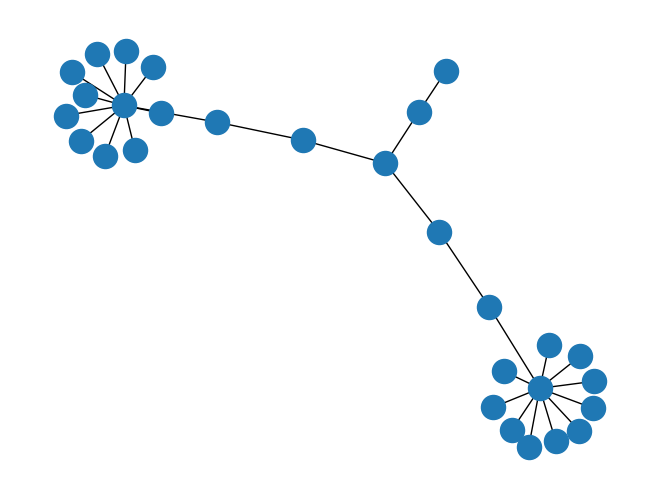

In [28]:
nx.draw(get_organ_graph('UBERON:0001465'))

## Generate a new integer-based ID, that takes into account the organ order
(This is necesary for the layout, later we can order the nodes and edges based on this integer ID, and then vega will visualize the organs in the desired order)

In [29]:
id_to_graph_int_id = {'UBERON:0013702': 0}

next_id = 1

for i, organ_id in enumerate(organ_order_in_id):
    branch_graph = get_organ_graph(organ_id)

    branch_graph_new_ids = dict(zip(nx.dfs_preorder_nodes(branch_graph, source=organ_id), range(next_id, next_id+branch_graph.number_of_nodes())))

    id_to_graph_int_id.update(branch_graph_new_ids)

    next_id += branch_graph.number_of_nodes()


In [30]:
nodes['graph_int_id'] = nodes['id'].map(id_to_graph_int_id)

In [31]:
nodes.head()

,id,name,type,organ,ontology_id,graph_int_id
0,UBERON:0013702,body,AS,body,UBERON:0013702,0
1,UBERON:0000948,heart,AS,blood_vasculature,UBERON:0000948,262
2,UBERON:0002079,left cardiac atrium,AS,blood_vasculature,UBERON:0002079,263
3,CL:0010008,cardiac endothelial cell,CT,blood_vasculature,CL:0010008,264
4,FMA:49913,Left inferior pulmonary vein,AS,blood_vasculature,FMA:49913,265


In [32]:
edges['source_int'] = edges['source'].map(id_to_graph_int_id)
edges['target_int'] = edges['target'].map(id_to_graph_int_id)

In [33]:
edges.head()

,organ,source,target,source_type,target_type,source_int,target_int
0,blood_vasculature,UBERON:0013702,UBERON:0000948,AS,AS,0,262
1,allen_brain,UBERON:0013702,UBERON:0000955,AS,AS,0,5185
3,bone_marrow,UBERON:0013702,UBERON:0002371,AS,AS,0,11849
4,eye,UBERON:0013702,UBERON:0000970,AS,AS,0,6053
5,fallopian_tube,UBERON:0013702,UBERON:0003889,AS,AS,0,10784


In [34]:
whole_graph_int = nx.from_pandas_edgelist(edges, source='source_int', target='target_int', edge_attr=True)

In [35]:
graph_int_id_to_id = {v: k for k, v in id_to_graph_int_id.items()}

In [36]:
id_to_graph_int_id['UBERON:0013702']

0

In [37]:
graph_int_id_to_id[0]

'UBERON:0013702'

In [38]:
get_nodes(name='body')

,id,name,type,organ,ontology_id,graph_int_id
0,UBERON:0013702,body,AS,body,UBERON:0013702,0


# Removal of the blood vasculature nodes from the whole (partonomy) graph
We only keep those that are necessary to keep the network connected

In [39]:
# remove those blood nodes from the graph, which if we remove, the graph will be still connected, repeat until no such node is found.
blood_nodes_candidates = set(nodes[nodes['organ']=='blood_vasculature'].graph_int_id.tolist())

distance_from_body = nx.single_source_shortest_path_length(whole_graph_int, source=0)

distance_from_body_blood_nodes = {k: v for k, v in distance_from_body.items() if k in blood_nodes_candidates}

node_visiting_order = sorted(distance_from_body_blood_nodes.items(), key=lambda x: x[1], reverse=True)

new_truncated_graph = whole_graph_int.copy()

for node in node_visiting_order:
    new_truncated_graph.remove_node(node[0])
    if nx.is_connected(new_truncated_graph):
        blood_nodes_candidates.remove(node[0])
    else:
        break


In [40]:
nodes['keep'] = nodes.apply(lambda row: True if (row['organ']!='blood_vasculature' or row['graph_int_id'] in blood_nodes_candidates) else False, axis=1)

In [41]:
truncated_nodes = nodes[nodes['keep']]
truncated_edges = edges[edges['source_int'].isin(truncated_nodes['graph_int_id']) | edges['target_int'].isin(truncated_nodes['graph_int_id'])]
truncated_graph = nx.from_pandas_edgelist(truncated_edges, source='source_int', target='target_int', edge_attr=True)

In [42]:
FTUs = ['UBERON:0001285', 'UBERON:0001229', 'UBERON:0004205', 'UBERON:0001289', 'UBERON:0004193', 'UBERON:0004204', 'UBERON:0001291', 'UBERON:0004203', #kidney
        'UBERON:0001983',  'UBERON:0001984',  #large intestine
        'UBERON:0004647', #liver
        'UBERON:0002299', 'UBERON:8410043', #lung 
        'UBERON:0000006', 'UBERON:0001263', 'UBERON:0014726', #pancreas
        'UBERON:0004179', #prostate gland
        'UBERON:0000412', 'UBERON:0013487', 'UBERON:0001992', #skin
        'UBERON:0001213', #small intestine
        'UBERON:0001250', 'UBERON:0001959', #spleen
        'UBERON:0002125' 
        ]

In [43]:
Main_Organs = list(nodes[nodes['ontology_id'].isin(list(nx.neighbors(whole_graph, 'UBERON:0013702')))]['id'])

In [44]:
def construct_network_create_vega_viz(nodes_dataframe, edges_dataframe, filename='butterfly', only_female=False, only_male=False, scenegraph=False, show_labels=False):
    '''
    Construct the network and create the vega visualization file, which is a JSON file. 
    Vega will visualize the network based on the config file. Using the API we can create the SVG and the "scenegraph" which will be used for the coordinates of the nodes.

    Parameters:
    nodes_dataframe: pd.DataFrame
        The dataframe containing the nodes of the network. It should have the following columns: 'id', 'name', 'type', 'organ', 'ontology_id', 'graph_int_id'.
    edges_dataframe: pd.DataFrame
        The dataframe containing the edges of the network. It should have the following columns: 'source_int', 'target_int', 'organ'.
    filename: str
        The name of the file to be saved
    only_female: bool
        If True, the visualization will not contain the prostate (so far that's the only male organ).
    only_male: bool
        If True, the visualization will not contain the ovaries, fallopian tube, uterus, placenta (so far these are the female organs).
    scenegraph: bool
        If True, the name of the nodes will be the id of the nodes. This is necessary to later get the coordinates of the nodes based on the IDs.
    show_labels: bool
        If True, the labels of the nodes will be shown (in the SVG file).
    '''

    nodes_df = nodes_dataframe.sort_values('graph_int_id').copy() 
    edges_df = edges_dataframe.sort_values('target_int').copy() #sorting is necessary for the order of the branches in the visualization

    # create the graph
    graph = nx.from_pandas_edgelist(edges_df, source='source_int', target='target_int', edge_attr=True)

    # get the parent of each node for the tree layout
    parents_dict = dict(nx.bfs_predecessors(graph, source=0))

    nodes_df['parent'] = nodes_df['graph_int_id'].map(parents_dict).fillna(0).astype(int)

    # set the color of the nodes based on the type
    nodes_df['color'] = nodes_df.apply(lambda row: '#56a04e' if row['ontology_id'] in FTUs else ('#984ea0' if row['type']=='AS' else '#ff7f00'), axis=1)


    # vega works with the id column, so we rename the id column to id_from_ontology_id
    nodes_df.rename(columns={'id': 'id_from_ontology_id', 'graph_int_id': 'id'}, inplace=True)
    

    if scenegraph:
        # the name has to be the id
        nodes_df.rename(columns={'name': 'name_label'}, inplace=True)
        nodes_df['name'] = nodes_df['id'].copy()


    # if the name is missing, we fill it with an empty string because vega gives an error if it is missing
    nodes_df['name'] = nodes_df['name'].fillna('')



    # from the female wing we remove the prostate
    if only_female and not only_male:
        nodes_df = nodes_df[nodes_df['organ']!='prostate']
        fn = filename + '_female'

    # from the male wing we remove the ovaries, fallopian tube, uterus, placenta
    elif only_male and not only_female:
        nodes_df = nodes_df[~nodes_df['organ'].isin(['fallopian_tube', 'ovary', 'uterus', 'placenta'])]
        fn = filename + '_male'

    elif not only_female and not only_male:
        fn = filename + '_full'

    else:
        raise ValueError('The parameters `only_female` and `only_male` cannot be both True at the same time.')

    # print(nodes_df['organ'].value_counts())

    # create the json file for the nodes
    nodes_json = nodes_df[['id', 'name', 'parent', 'type', 'ontology_id', 
                           'id_from_ontology_id', 'color', 'organ', #'organ_label'
                           ]].to_dict(orient='index')

    # the body does not have a parent, so we delete its value
    del(nodes_json[0]['parent'])

    # we need to convert the dictionary to a list, that's how the vega visualization expects it at the config['data'][0]['values']
    nodes_json = [nodes_json[i] for i in nodes_json.keys()]
    
    # load the vega config file
    with open(f'{output_path}/vega_config/vega_config.json', encoding='utf8') as json_file:
        config = json.load(json_file)

    # set the data in the config file
    config['data'][0]['values'] = nodes_json
    
    # show labels if show_labels is True
    if show_labels:
        config['marks'][-1]['encode']['update']['opacity']['signal'] = config['marks'][-1]['encode']['update']['opacity']['signal'][:-1] + '1' # show the labels, by default they are hidden
    
    # create the json file and save it
    with open(f"{output_path}/{fn}_vega_viz_config.json", "w") as outfile:
        outfile.write(json.dumps(config, indent=4))
        print(f'File saved as "{output_path}/{fn}_vega_viz.json"')
    
    return config

In [45]:
vega_config = construct_network_create_vega_viz(truncated_nodes, truncated_edges, scenegraph=True)

File saved as "./viz_v2.0/butterfly_full_vega_viz.json"


In [46]:
def update_vega_config(vega_config_names, filename):
    for item in vega_config_names['data'][0]['values']:
        if item['ontology_id'] not in FTUs and item['ontology_id'] not in Main_Organs:
            item['name'] = ''
        
    with open(f"{output_path}/butterfly_names_{filename}_vega_viz_updated.json", "w") as outfile:
        outfile.write(json.dumps(vega_config_names, indent=4))
        print(f'File saved as "{output_path}/butterfly_names_{filename}_vega_viz_updated.json"')

    return vega_config_names

In [47]:
vega_config_female_with_ids = construct_network_create_vega_viz(truncated_nodes, truncated_edges, only_female=True, scenegraph=True, show_labels=True, filename='butterfly_ids') #id shown - this is used for the coordinates 
vega_config_female = construct_network_create_vega_viz(truncated_nodes, truncated_edges, only_female=True, scenegraph=True, show_labels=False) #no name or id shown, based on id (scenegraph) - this is used for the viz

File saved as "./viz_v2.0/butterfly_ids_female_vega_viz.json"
File saved as "./viz_v2.0/butterfly_female_vega_viz.json"


In [48]:
vega_config_male_with_ids = construct_network_create_vega_viz(truncated_nodes, truncated_edges, only_male=True, scenegraph=True, show_labels=True, filename='butterfly_ids')
vega_config_male = construct_network_create_vega_viz(truncated_nodes, truncated_edges, only_male=True, scenegraph=True)

File saved as "./viz_v2.0/butterfly_ids_male_vega_viz.json"
File saved as "./viz_v2.0/butterfly_male_vega_viz.json"


In [49]:
vega_config_female_with_names = construct_network_create_vega_viz(truncated_nodes, truncated_edges, only_female=True, scenegraph=False, show_labels=True, filename='butterfly_names') 
vega_config_female_with_names = update_vega_config(vega_config_female_with_names, 'female')

vega_config_male_with_names = construct_network_create_vega_viz(truncated_nodes, truncated_edges, only_male=True, scenegraph=False, show_labels=True, filename='butterfly_names') 
vega_config_male_with_names = update_vega_config(vega_config_male_with_names, 'male')

File saved as "./viz_v2.0/butterfly_names_female_vega_viz.json"
File saved as "./viz_v2.0/butterfly_names_female_vega_viz_updated.json"
File saved as "./viz_v2.0/butterfly_names_male_vega_viz.json"
File saved as "./viz_v2.0/butterfly_names_male_vega_viz_updated.json"


In [50]:
def create_vega_viz(config, filename, scenegraph=False):
    '''
    Create the visualization based on the vega config file. The visualization can be saved as SVG or as a scenegraph JSON file.

    Parameters:
    config: dict
        The vega config file.
    filename: str
        The name of the file to be saved.
    scenegraph: bool
        If True, the scenegraph JSON file will be saved, otherwise the SVG file will be saved.
    '''

    if scenegraph:
        scenegraph_data = vlc.vega_to_scenegraph(vg_spec=config)

        with open(f"{output_path}/vega_{filename}_scenegraph.json", "w") as outfile:
            outfile.write(json.dumps(scenegraph_data, indent=4))

        return scenegraph_data
    
    else:
        svg_str = vlc.vega_to_svg(vg_spec=config,)

        with open(f"{output_path}/vega_{filename}_viz.svg", "wt") as f:
            f.write(svg_str)

        return svg_str

In [51]:
%%time
female_svg_names = create_vega_viz(vega_config_female_with_names, 'female_name', scenegraph=False)

CPU times: user 1.35 s, sys: 85.7 ms, total: 1.44 s
Wall time: 1.18 s


In [52]:
%%time
male_svg_names = create_vega_viz(vega_config_male_with_names, 'male_name', scenegraph=False)

CPU times: user 491 ms, sys: 5.65 ms, total: 497 ms
Wall time: 374 ms


In [53]:
scenegraph_female = create_vega_viz(vega_config_female_with_ids, 'female_id', scenegraph=True)
scenegraph_male = create_vega_viz(vega_config_male_with_ids, 'male_id', scenegraph=True)

In [54]:
def get_node_coordinates(scenegraph):
    return {item['text']: (item['x'], item['y']) for item in scenegraph['scenegraph']['items'][0]['items'][2]['items']}

In [55]:
coordinates_of_nodes_fem = get_node_coordinates(scenegraph_female)
coordinates_of_nodes_mal = get_node_coordinates(scenegraph_male)

# Vasculature 

In [56]:
blood_edges = pd.read_csv(blood_edges_url)

blood_graph = nx.from_pandas_edgelist(blood_edges, source='source', target='target', edge_attr=True,)# create_using=nx.DiGraph)

blood_nodes = nodes[nodes['id'].isin(blood_graph.nodes)]

blood_nodes['graph_int_id'] = blood_nodes['id'].map(id_to_graph_int_id)

blood_edges['source_int'] = blood_edges['source'].map(id_to_graph_int_id)
blood_edges['target_int'] = blood_edges['target'].map(id_to_graph_int_id)

/tmp/ipykernel_129783/467229484.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blood_nodes['graph_int_id'] = blood_nodes['id'].map(id_to_graph_int_id)


In [57]:
#edges in blood_graph that are not in whole graph:
new_edges = []
for edge in blood_graph.edges:
    if not whole_graph.has_edge(*edge):
        new_edges.append(edge)

In [58]:
len(new_edges)

324

In [59]:
blood_graph_int = nx.from_pandas_edgelist(blood_edges, source='source_int', target='target_int', edge_attr=True)

In [60]:
id_of_heart = blood_nodes[blood_nodes['name']=='heart']['graph_int_id'].values[0]

In [61]:
id_of_heart

262

In [62]:
blood_nodes[blood_nodes['graph_int_id'].isin(list(nx.neighbors(blood_graph_int, id_of_heart)))]

,id,name,type,organ,ontology_id,graph_int_id,keep
2,UBERON:0002079,left cardiac atrium,AS,blood_vasculature,UBERON:0002079,263,True
37,UBERON:0002084,heart left ventricle,AS,blood_vasculature,UBERON:0002084,336,True
3236,UBERON:0002078,right cardiac atrium,AS,blood_vasculature,UBERON:0002078,3582,True
4354,UBERON:0002080,heart right ventricle,AS,blood_vasculature,UBERON:0002080,4738,True


In [63]:
components = blood_graph_int.copy()
components.remove_node(id_of_heart)
components = list(nx.connected_components(components))

In [64]:
len(components)

4

In [65]:
components += [set([id_of_heart])]

In [66]:
id_of_left_ventricle_and_left_atrium = blood_nodes[blood_nodes['name'].apply(lambda x: 'left cardiac atrium' in str(x).lower() or 'left ventricle' in str(x).lower())]['graph_int_id'].tolist()

id_of_right_ventricle_and_right_atrium = blood_nodes[blood_nodes['name'].apply(lambda x: 'right cardiac atrium' in str(x).lower() or 'right ventricle' in str(x).lower())]['graph_int_id'].tolist()

In [67]:
id_of_left_ventricle_and_left_atrium

[263, 336]

In [68]:
id_of_right_ventricle_and_right_atrium

[3582, 4738]

In [69]:
blood_nodes['artery/vein'] = blood_nodes['graph_int_id'].apply(lambda x: 'artery' if set(id_of_left_ventricle_and_left_atrium+[id_of_heart]).intersection(set([comp for comp in components if x in comp][0])) else 'vein')

/tmp/ipykernel_129783/1156918371.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blood_nodes['artery/vein'] = blood_nodes['graph_int_id'].apply(lambda x: 'artery' if set(id_of_left_ventricle_and_left_atrium+[id_of_heart]).intersection(set([comp for comp in components if x in comp][0])) else 'vein')


In [70]:
blood_nodes['artery/vein'].value_counts(dropna=False)

artery/vein
artery    3322
vein      1326
Name: count, dtype: int64

In [71]:
blood_nodes

,id,name,type,organ,ontology_id,graph_int_id,keep,artery/vein
1,UBERON:0000948,heart,AS,blood_vasculature,UBERON:0000948,262,True,artery
2,UBERON:0002079,left cardiac atrium,AS,blood_vasculature,UBERON:0002079,263,True,artery
3,CL:0010008,cardiac endothelial cell,CT,blood_vasculature,CL:0010008,264,True,artery
4,FMA:49913,Left inferior pulmonary vein,AS,blood_vasculature,FMA:49913,265,True,artery
5,CL:0000071,blood vessel endothelial cell,CT,blood_vasculature,CL:0000071,266,True,artery
...,...,...,...,...,...,...,...,...
11303,UBERON:0015173$$8124,arcuate artery of uterus,AS,uterus,UBERON:0015173,11358,True,artery
11306,UBERON:0015173$$8126,arcuate artery of uterus,AS,uterus,UBERON:0015173,11581,True,artery
11309,UBERON:0015173$$8128,arcuate artery of uterus,AS,uterus,UBERON:0015173,11172,True,artery
11312,UBERON:0015173$$8130,arcuate artery of uterus,AS,uterus,UBERON:0015173,11395,True,artery


In [72]:
# those nodes whose ontology id is in both blood and whole graph but not in 'blood_vasculature' organ
nodes_except_blood = nodes[nodes['organ']!='blood_vasculature']
# matching nodes between blood vasculature and other organs
matching_nodes = nodes_except_blood[nodes_except_blood['id'].isin(blood_nodes['id'])]

In [73]:
def get_coordinates_for_blood_nodes(coordinates_of_nodes, only_female=False, only_male=False, bundle_edges=False):
    '''
    Get the coordinates of the blood nodes based on the coordinates of the partonomy graph nodes.

    Parameters:
    coordinates_of_nodes: dict
        The dictionary containing the coordinates of the nodes.
    only_female: bool
        If True, the visualization will not contain the prostate (so far that's the only male organ).
    only_male: bool
        If True, the visualization will not contain the ovaries, fallopian tube, uterus, placenta.
    bundle_edges: bool
        If True, the edges will be bundled (for the final viz, this is used).

    '''

    if only_female and not only_male:
        matching_nodes_filtered = matching_nodes[matching_nodes['organ']!='prostate'].copy()
        filename='female'

    elif only_male and not only_female:
        matching_nodes_filtered = matching_nodes[~matching_nodes['organ'].isin(['fallopian_tube', 'ovary', 'uterus', 'placenta'])].copy()
        filename='male'

    else:
        raise ValueError('Set either only_female or only_male parameters True')
    
    
    #Get the pruned blood graph

    parents = set(matching_nodes_filtered['graph_int_id'].tolist())

    # get the parent of each node for the tree layout
    blood_parents_dict = dict(nx.bfs_predecessors(blood_graph_int, source=262))

    pruned_blood_nodes = parents.copy()

    while len(parents)>0:
        parents = set([blood_parents_dict[node] for node in parents if node in blood_parents_dict]) - pruned_blood_nodes

        pruned_blood_nodes = pruned_blood_nodes.union(parents)


    
    pruned_blood_nodes = blood_nodes[blood_nodes['graph_int_id'].isin(pruned_blood_nodes)]

    pruned_blood_graph = nx.induced_subgraph(blood_graph_int, pruned_blood_nodes['graph_int_id'].tolist())

    veins = blood_nodes[blood_nodes['artery/vein']=='vein']['graph_int_id'].tolist()
    arteries = blood_nodes[blood_nodes['artery/vein']=='artery']['graph_int_id'].tolist()

    graphs = {'veins': nx.induced_subgraph(pruned_blood_graph, veins+[id_of_heart]), 'arteries': nx.induced_subgraph(pruned_blood_graph, arteries)}


    # get the coordinates of the nodes
    pruned_blood_nodes['coordinates'] = pruned_blood_nodes['graph_int_id'].apply(lambda x: coordinates_of_nodes[x] if x in coordinates_of_nodes else np.nan)

    pruned_blood_nodes = pruned_blood_nodes.dropna(subset=['coordinates'])

    pruned_blood_nodes.set_index('graph_int_id', inplace=True)

    coordinates = {'veins': pruned_blood_nodes[(pruned_blood_nodes['artery/vein']=='vein')|(pruned_blood_nodes['name']=='heart')]['coordinates'].to_dict(), 
                   'arteries': pruned_blood_nodes[pruned_blood_nodes['artery/vein']=='artery']['coordinates'].to_dict()}

    fixed_nodes = {'veins': pruned_blood_nodes[(pruned_blood_nodes['artery/vein']=='vein')|(pruned_blood_nodes['name']=='heart')].index.tolist(), 
                   'arteries': pruned_blood_nodes[pruned_blood_nodes['artery/vein']=='artery'].index.tolist()}

    pos = {}

    pos['veins'] = nx.spring_layout(graphs['veins'], pos=coordinates['veins'], fixed=fixed_nodes['veins'], seed=42, iterations=1000, dim=2, k=0.01/np.sqrt(len(graphs['veins'])))
    pos['arteries'] = nx.spring_layout(graphs['arteries'], pos=coordinates['arteries'], fixed=fixed_nodes['arteries'], seed=42, iterations=1000, dim=2, k=0.01/np.sqrt(len(graphs['arteries'])))


    # return graphs, pos, fixed_nodes

    if not bundle_edges:
        plt.figure(figsize=(canvas_size/100,canvas_size/100))
        plt.axes().set_aspect('equal')
        plt.margins(x=0, y=0)
        plt.xlim(0,canvas_size)
        plt.ylim(0, canvas_size)
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0, wspace=0)
        plt.tight_layout(pad=0, h_pad=0, w_pad=0, rect=(0,0,1,1))
        plt.axis('off') 

        nx.draw(graphs['arteries'], pos=pos['arteries'], node_size=10, edge_color='tab:red', node_color='tab:red')
        nx.draw(graphs['veins'], pos=pos['veins'], node_size=10, edge_color='tab:blue', node_color='tab:blue')
        nx.draw_networkx_nodes(graphs['arteries'], pos=pos['arteries'], nodelist=[id_of_heart], node_size=40, node_color='tab:red', node_shape='p')

        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
        plt.tight_layout(pad=0, h_pad=0, w_pad=0, rect=(0,0,1,1))
        plt.axis('off')
        plt.gca().set_axis_off()
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
        plt.margins(0,0)
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.savefig(f'{output_path}/blood_viz_{filename}.pdf',  transparent=True, pad_inches=0.0, bbox_inches=0)
        print(f'Fig saved as "{output_path}/blood_viz_{filename}.pdf"')
        plt.show()

    else:
        # nodes_only = {'veins': pd.DataFrame.from_dict(relabel_mapping_inv['veins'], orient='index').rename(columns={0:'name'}), 
        #     'arteries': pd.DataFrame.from_dict(relabel_mapping_inv['arteries'], orient='index').rename(columns={0:'name'})}
        
        # nodes = {'veins': pd.DataFrame.from_dict(pos2['veins']).T.rename(columns={0:'x', 1:'y'}).join(nodes_only['veins'])[['name', 'x', 'y']], 
        #          'arteries': pd.DataFrame.from_dict(pos2['arteries']).T.rename(columns={0:'x', 1:'y'}).join(nodes_only['arteries'])[['name', 'x', 'y']]}
        
        # edges = {'veins': nx.to_pandas_edgelist(renamed_comp['veins'])[['source', 'target']], 
        #          'arteries': nx.to_pandas_edgelist(renamed_comp['arteries'])[['source', 'target']]}
        # hb = hammer_bundle(nodes, edges, initial_bandwidth=0.03,tension=0.9, accuracy=8000)
        edges = {'veins': nx.to_pandas_edgelist(graphs['veins'], source='source_int', target='target_int')[['source_int', 'target_int']].rename(columns={'source_int': 'source', 'target_int': 'target'}),
                 'arteries': nx.to_pandas_edgelist(graphs['arteries'],  source='source_int', target='target_int')[['source_int', 'target_int']].rename(columns={'source_int': 'source', 'target_int': 'target'}),
                 }
        nodes = {'veins': pd.DataFrame.from_dict(pos['veins']).T.rename(columns={0:'x', 1:'y'}),#.reset_index(names=['name']),#.join(pruned_blood_nodes[['name', 'artery/vein']]), 
                 'arteries': pd.DataFrame.from_dict(pos['arteries']).T.rename(columns={0:'x', 1:'y'})#.join(pruned_blood_nodes[['name', 'artery/vein']])
                 }
        
        
        hb = {'veins': hammer_bundle(nodes['veins'], edges['veins'], initial_bandwidth=.015, decay=0.8, tension=0.99, accuracy=1000), 
              'arteries': hammer_bundle(nodes['arteries'], edges['arteries'], initial_bandwidth=.015, decay=0.8, tension=0.99, accuracy=1000)}
        
        plt.figure(figsize=(canvas_size/100, canvas_size/100))
        plt.axes().set_aspect('equal')
        plt.margins(x=0, y=0)
        plt.xlim(0,canvas_size)
        plt.ylim(-canvas_size, 0)
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0, hspace=0, wspace=0)
        plt.tight_layout(pad=0, h_pad=0, w_pad=0, rect=(0,0,1,1))
        plt.axis('off')

        plt.plot(hb['veins']['x'], -hb['veins']['y'], color='tab:blue', alpha=0.8)
        plt.plot(hb['arteries']['x'], -hb['arteries']['y'], color='tab:red', alpha=0.8)

        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
        plt.tight_layout(pad=0, h_pad=0, w_pad=0, rect=(0,0,1,1))
        plt.axis('off')
        plt.gca().set_axis_off()
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
        plt.margins(0,0)
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        
        plt.savefig(f'{output_path}/blood_viz_{filename}_bundled.svg', pad_inches=0.0, transparent=True, bbox_inches=0)
        print(f'Fig saved as "{output_path}/blood_viz_{filename}_bundled.svg"')
        plt.show()
    
        # return hb

/tmp/ipykernel_129783/891491612.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pruned_blood_nodes['coordinates'] = pruned_blood_nodes['graph_int_id'].apply(lambda x: coordinates_of_nodes[x] if x in coordinates_of_nodes else np.nan)


Fig saved as "./viz_v2.0/blood_viz_female_bundled.svg"


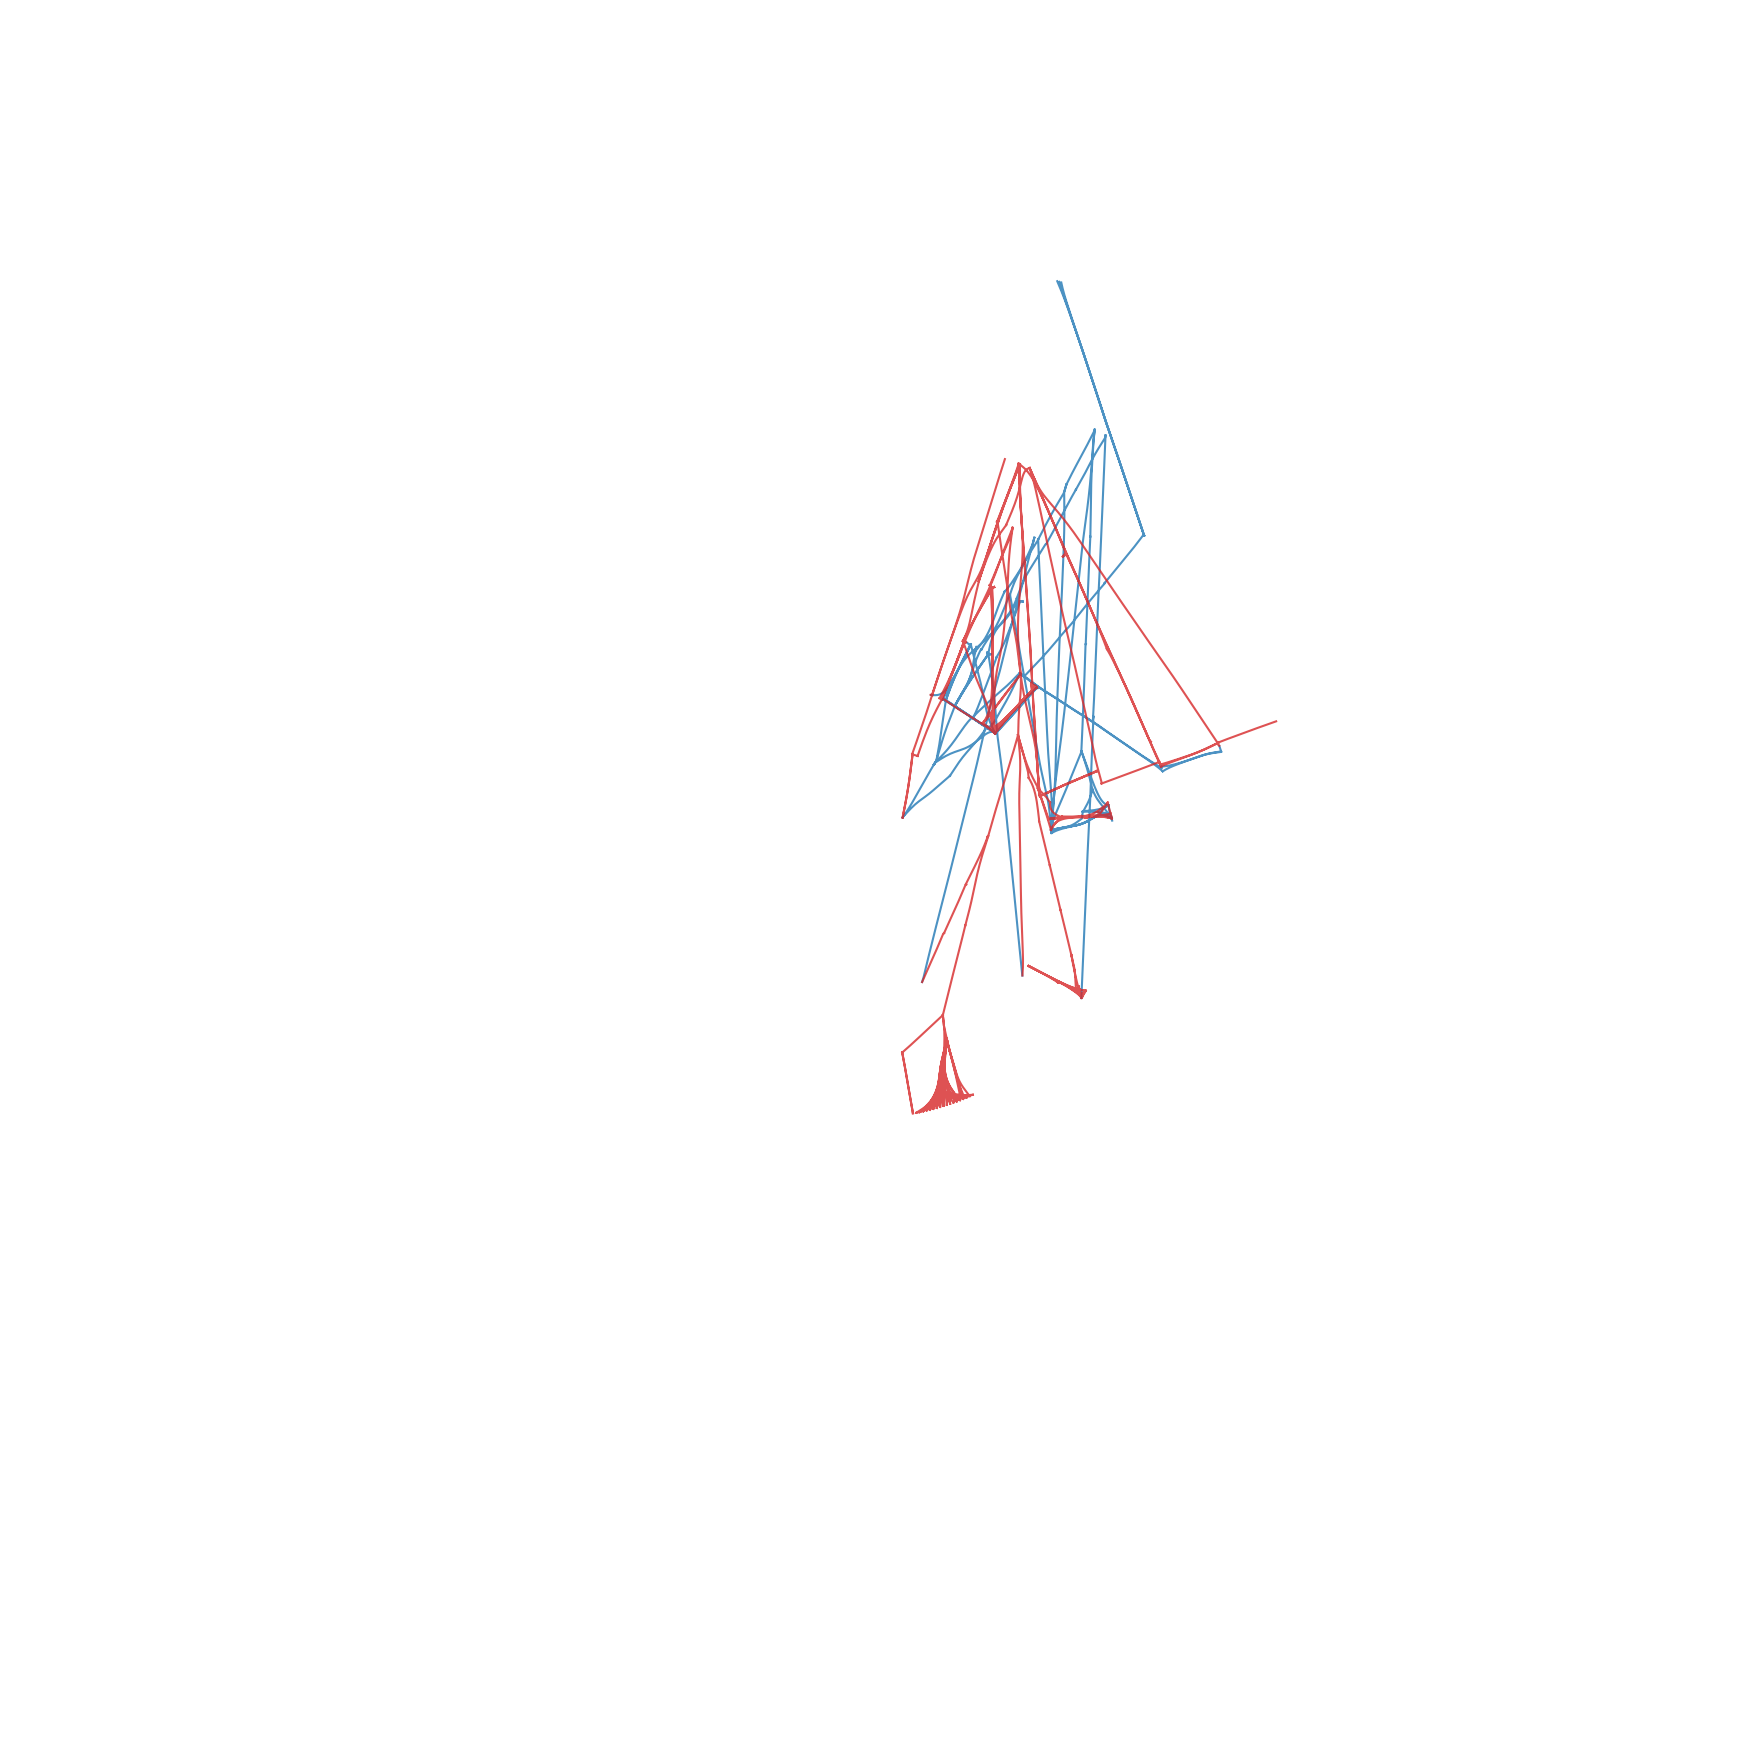

In [74]:
get_coordinates_for_blood_nodes(coordinates_of_nodes_fem, only_female=True, bundle_edges=True)

/tmp/ipykernel_129783/891491612.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pruned_blood_nodes['coordinates'] = pruned_blood_nodes['graph_int_id'].apply(lambda x: coordinates_of_nodes[x] if x in coordinates_of_nodes else np.nan)


Fig saved as "./viz_v2.0/blood_viz_male_bundled.svg"


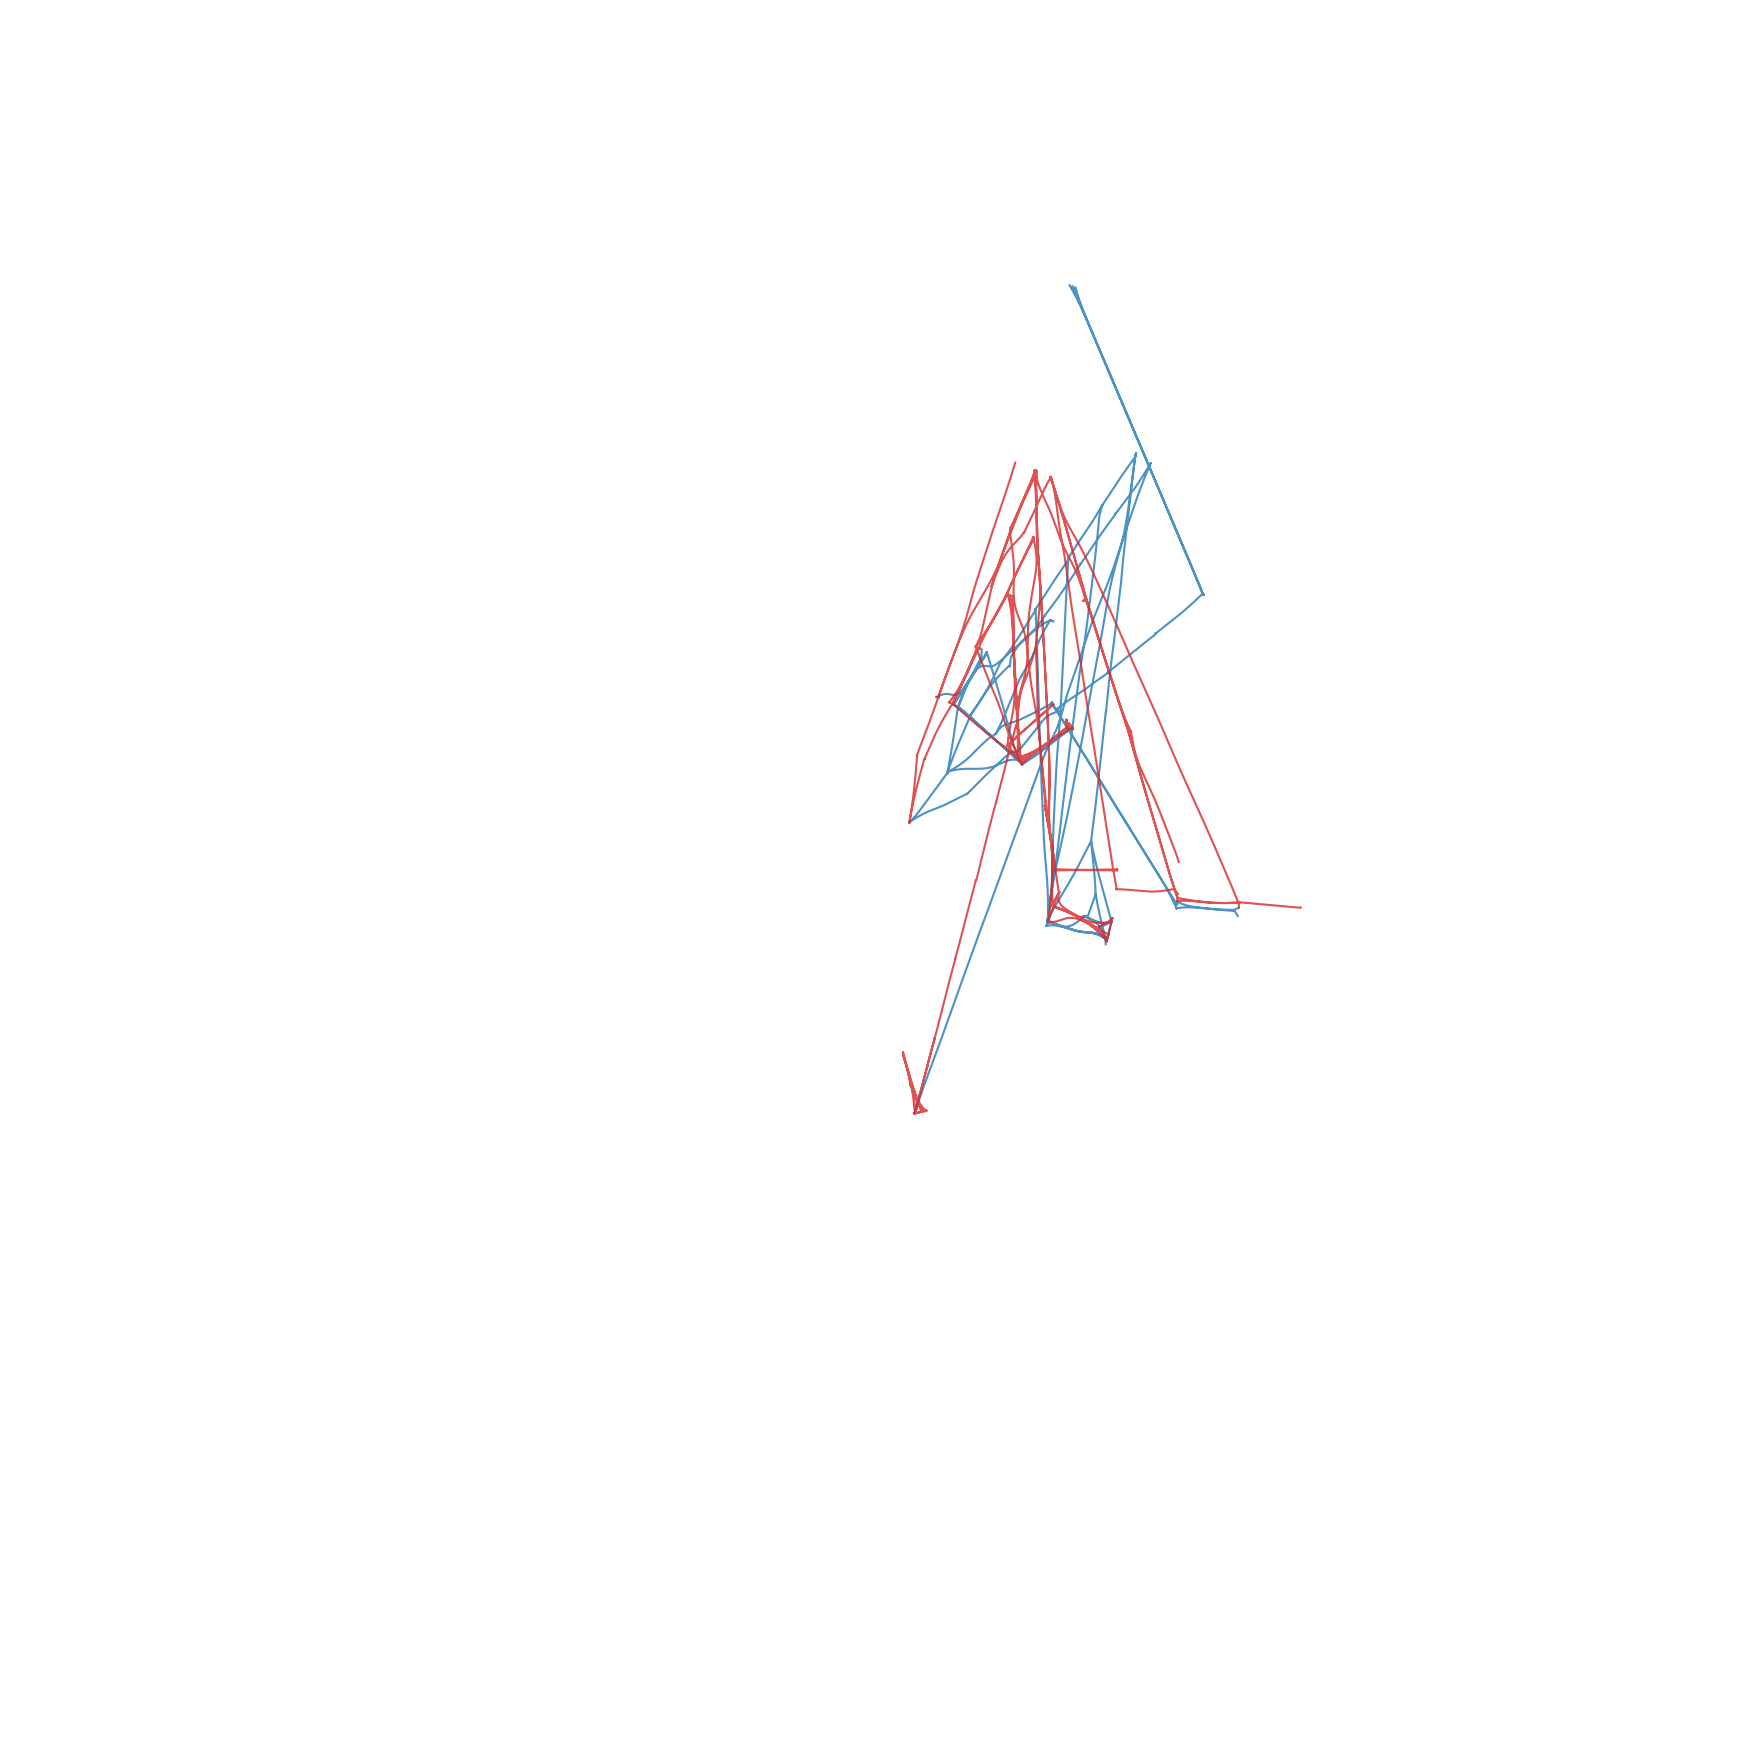

In [75]:
get_coordinates_for_blood_nodes(coordinates_of_nodes_mal, only_male=True, bundle_edges=True)

# Overlay the SVG figures using svgutils

In [76]:
def flip_text_horizontally(input_file, output_file):
    # Parse the SVG file
    tree = ET.parse(input_file)
    root = tree.getroot()

    # Get the SVG namespace
    ns = {'svg': 'http://www.w3.org/2000/svg'}
    ET.register_namespace('', ns['svg'])  # Prevent unnecessary prefixes in output

    # Loop through all text elements in the SVG
    for text_element in root.findall('.//svg:text', ns):
        # Get the text element's position (x, y)
        x = float(text_element.attrib.get('x', '0'))
        y = float(text_element.attrib.get('y', '0'))

        # Apply a transformation to flip the text horizontally
        current_transform = text_element.attrib.get('transform', '')
        flip_transform = f"translate({2 * x}, 0) scale(-1, 1)"
        text_element.set('transform', f"{current_transform} {flip_transform}".strip())

    # Save the modified SVG
    tree.write(output_file)
    print(f"Text-flipped SVG saved to {output_file}")

In [77]:
# Example usage
input_svg = f"{output_path}/vega_female_name_viz.svg"  # Path to your input SVG file
output_svg = f"{output_path}/vega_female_name_viz_flipped.svg"
flip_text_horizontally(input_svg, output_svg)

Text-flipped SVG saved to ./viz_v2.0/vega_female_name_viz_flipped.svg


In [78]:
template = st.fromfile(f'{output_path}/vega_female_name_viz_flipped.svg')
template.set_size(size=(str(canvas_size), str(canvas_size)))
second_svg = st.fromfile(f'{output_path}/blood_viz_female_bundled.svg')
second_svg.set_size(size=(str(canvas_size), str(canvas_size)))

In [79]:
print(template.height, template.width) 
print(second_svg.height, second_svg.width) 

1720 1720
1720 1720


In [80]:
template.append(second_svg)
template.save(f'{output_path}/female_butterfly_wing.svg')

In [81]:
template = st.fromfile(f'{output_path}/vega_male_name_viz.svg')
template.set_size(size=(str(canvas_size), str(canvas_size)))
second_svg = st.fromfile(f'{output_path}/blood_viz_male_bundled.svg')
second_svg.set_size(size=(str(canvas_size), str(canvas_size)))

In [82]:
print(template.height, template.width) 
print(second_svg.height, second_svg.width) 

1720 1720
1720 1720


In [83]:
template.append(second_svg)
template.save(f'{output_path}/male_butterfly_wing.svg')

# In Adobe Illustrator
Place female_butterfly_wing.svg in AI:

X: 860

Y: 890

Flip it horizontally,

Place male_butterfly_wing.svg:

X: 920

Y: 890

Add legend and Save file